# Stock Predictor
LSTM architecture to predict Stockprices based on [this Kaggle Dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)


In [16]:
%matplotlib inline
from IPython.display import display, clear_output
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [62]:
csv = pd.read_csv('./googl.us.txt')
csv.drop(columns=["OpenInt", "Date"], inplace=True)
data = torch.tensor(csv.values, dtype=torch.float)
print(data.size()[0])

3333


In [51]:
class StockPredictor(nn.Module):
    def __init__(self, layers):
        super(StockPredictor, self).__init__()
        self.layers = layers
        self.lstm = nn.LSTM(5, 5, layers)
        self.final = nn.Linear(5, 1)
    def forward(self, stockAtDate, keep_hidden_state=False):
        if not keep_hidden_state:
            self.hidden = (torch.randn(self.layers, 1, 5),
                       torch.randn(self.layers, 1, 5))
        out, self.hidden = self.lstm(stockAtDate, self.hidden)
        out = self.final(out)
        return out

In [52]:
model = StockPredictor(2)
optim = torch.optim.Adam(model.parameters(), lr=0.1)
loss_function = nn.MSELoss()

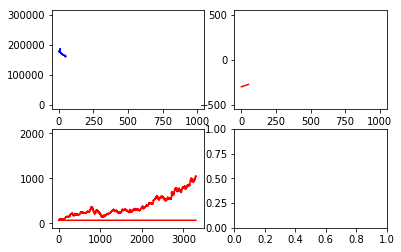

In [ ]:
test_seperate = 3000
epochs = 1000
losses = []
deltas = []
fig, ((lax, dax), (cmpax, _)) = plt.subplots(ncols=2, nrows=2)
lplot, = lax.plot([0, epochs], [300000, 0], 'b')
dplot, = dax.plot([0, epochs], [500, -500], 'r')
rplot, = cmpax.plot([0, data.size()[0]], [0, 2000], 'r')
pplot, = cmpax.plot([0, data.size()[0]], [0, 2000], 'r')
for epoch in range(epochs):
    model.zero_grad()
    inputs = data[:-30, :].view(-1, 1, 5) #inferring length of the sequence
    target = data[30:, 3]
    prediction = model(inputs)
    loss = loss_function(prediction[0,0], target.view(1, -1))
    loss.backward()
    optim.step()
    delta = model(data[:test_seperate, :].view(-1, 1, 5)) - data[30:test_seperate+30, 3]
    # visualising learning progress
    deltas.append(np.asscalar(delta.mean().detach().numpy()))
    losses.append(np.asscalar(loss.detach().numpy()))
    lplot.set_data(range(epoch+1), losses)
    dplot.set_data(range(epoch+1), deltas)
    rplot.set_data(range(data.size()[0]-30), target.detach().numpy())
    pplot.set_data(range(data.size()[0]-30), prediction.detach().numpy())
    clear_output(wait=True)
    display(fig)
    print(f'\r{epoch}: {abs(delta.mean())} | {loss}')
    
plt.show()    
    